## Valid Word List Maker

## Import libraries

In [1]:
import os
import re
import csv
import time
import gzip
import string
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import words as wordnet_words
from nltk.corpus import wordnet as wn

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import SnowballStemmer

## Prepare for processing

In [2]:
UNIGRAMS_DATASET_FOLDER_PATH = './datasets/1-grams'
VALID_WORDS_DATASET_PATH = './datasets/filtered_words.txt'

UNIGRMS_MIN_FREQUENCY = 10000
START_YEAR_DATA_ANALYZE = 1900
END_YEAR_DATA_ANALYZE = 2019

UNIGRAMS_WORD_POS_TO_SUBSTR = {
    "NOUN",
    "VERB",
    "ADJ",
    "ADV",
    "PRON",
    "DET",
    "ADP",
    "NUM",
    "CONJ",
    "PRT",
}

UNIGRAMS_DATA_FILES = [file for file in os.listdir(UNIGRAMS_DATASET_FOLDER_PATH) if file.endswith('.gz')]

VALID_WORDS_SET = set()
VALID_WORDS = dict() # word: [frequency, stem, stem_valid_probability]

PS = PorterStemmer()
LS = LancasterStemmer()
SS = SnowballStemmer(language='english')

In [3]:
def word_contains_only_ascii_letters(word: str) -> bool:
    for char in word:
        if char not in string.ascii_letters:
            return False

    return True

## Parse valid words dataset

In [4]:
parse_valid_words_start_time = time.time()

with open(VALID_WORDS_DATASET_PATH, 'r') as dataset:
    for line in dataset:
        word = line.rstrip('\n')
        VALID_WORDS_SET.add(word)

parse_valid_words_end_time = time.time()
difference_time_in_ms = round(1000 * (parse_valid_words_end_time - parse_valid_words_start_time), 2)

print("Total words:", len(VALID_WORDS_SET))
print("Total time:", difference_time_in_ms, "ms")

Total words: 416283
Total time: 130.92 ms


## Parse unigrams

In [5]:
def to_valid_unigram(unigram: str) -> str | None:
    last_underscore_index = unigram.rfind('_')
    if last_underscore_index == -1:
        return

    unigram_substr = unigram[:last_underscore_index]
    pos_substr = unigram[last_underscore_index + 1:]

    if pos_substr in UNIGRAMS_WORD_POS_TO_SUBSTR and word_contains_only_ascii_letters(unigram_substr):
        return unigram_substr.lower()

In [ ]:
parse_unigrams_start_time = time.time()

for unigram_filename in UNIGRAMS_DATA_FILES:
    filepath = os.path.join(UNIGRAMS_DATASET_FOLDER_PATH, unigram_filename)
    process_gzip_start_time = time.time()

    with gzip.open(filepath, 'rt', encoding='utf-8') as gz_file:
        processed_lines = 0
        valid_words = 0
        for line in gz_file:
            splitted_line = line.split('\t')
            unigram = splitted_line[0]

            valid_unigram = to_valid_unigram(unigram)
            if valid_unigram and valid_unigram in VALID_WORDS_SET:
                years_data = splitted_line[1:]

                count = 0
                for year_data in years_data:
                    splitted_years_data = year_data.split(',')
                    year = int(splitted_years_data[0])
                    if year >= START_YEAR_DATA_ANALYZE and year <= END_YEAR_DATA_ANALYZE:
                        frequency = int(splitted_years_data[1])
                        count += frequency

                if count >= UNIGRMS_MIN_FREQUENCY:
                    if valid_unigram in VALID_WORDS:
                        VALID_WORDS[valid_unigram][0] += count
                    else:
                        VALID_WORDS[valid_unigram] = [count, None, None]
                        valid_words += 1

            processed_lines += 1

    print(f"\t{unigram_filename}")
    print("Total words:", processed_lines)
    print("Valid words:", valid_words)
    print("Time:", round(time.time() - process_gzip_start_time, 2), "s")

parse_unigrams_end_time = time.time()

print("-" * 30)
print("Valid words:", len(VALID_WORDS))
print("Total time:", round(parse_unigrams_end_time - parse_unigrams_start_time, 2), "s")

## Save / load parsed VALID_WORDS dict

In [6]:
import pickle

In [8]:
# Save data
file_path = "datasets/parsed_words_data.pkl"

with open(file_path, 'wb') as f:
    pickle.dump(VALID_WORDS, f)

In [7]:
# Load data
file_path = "datasets/parsed_words_data.pkl"

with open(file_path, 'rb') as f:
    VALID_WORDS = pickle.load(f)

## Caclulate stems validity probability

In [8]:
def calculate_stem_valid_probability(word_freq: int, stem_freq: int) -> float:
    if stem_freq <= 1:
        return 0.001

    if word_freq <= 1:
        return 0.999

    log_ratio = np.log(stem_freq / word_freq)
    probability = 1 / (1 + np.exp(-log_ratio))

    if probability < 0.001:
        return 0.001

    if probability > 0.999:
        return 0.999

    return round(probability, 4)

In [9]:
# Main idea from https://stackoverflow.com/a/52142282/15070145

# List of prefixes from https://dictionary.cambridge.org/grammar/british-grammar/word-formation/prefixes
ENGLISH_PREFIXES = sorted([
    "anti",     # anti-goverment, anti-racist, anti-war
    "auto",     # autobiography, automobile
    "de",       # de-classify, decontaminate, demotivate
    "dis",      # disagree, displeasure, disqualify
    "down",     # downgrade, downhearted
    "extra",    # extraordinary, extraterrestrial
    "hyper",    # hyperactive, hypertension
    "il",       # illegal
    "im",       # impossible
    "in",       # insecure
    "ir",       # irregular
    "inter",    # interactive, international
    "mega",     # megabyte, mega-deal, megaton
    "mid",      # midday, midnight, mid-October
    "mis",      # misaligned, mislead, misspelt
    "non",      # non-payment, non-smoking
    "over",     # overcook, overcharge, overrate
    "out",      # outdo, out-perform, outrun
    "post",     # post-election, post-warn
    "pre",      # prehistoric, pre-war
    "pro",      # pro-communist, pro-democracy
    "re",       # reconsider, redo, rewrite
    "semi",     # semicircle, semi-retired
    "sub",      # submarine, sub-Saharan
    "super",    # super-hero, supermodel
    "tele",     # television, telephathic
    "trans",    # transatlantic, transfer
    "ultra",    # ultra-compact, ultrasound
    "un",       # under-cook, underestimate
    "up"        # upgrade, uphill
], key=len, reverse=True)

WORDS_WHITELIST = set(list(wn.words()) + wordnet_words.words())

In [10]:
def stem_prefix(word, prefixes, roots):
    original_word = word
    for prefix in sorted(prefixes, key=len, reverse=True):
        word, nsub = re.subn("^{}[\-]?".format(prefix), "", word)
        if nsub > 0 and word in roots:
            return word

    return original_word

In [11]:
probabilities = []
word_and_stem_frequencies = []

for valid_word, word_data in VALID_WORDS.items():
    if len(valid_word) <= 3:
        continue

    word_frequency, _, _ = word_data

    stems = set()
    stems.add(PS.stem(valid_word))
    stems.add(LS.stem(valid_word))
    stems.add(SS.stem(valid_word))

    stemmed_prefixes = set()
    for stem in stems:
        stemmed_prefix_word = stem_prefix(stem, ENGLISH_PREFIXES, WORDS_WHITELIST)
        if stem != stemmed_prefix_word:
            stemmed_prefixes.add(stemmed_prefix_word)

    stems.update(stemmed_prefixes)

    best_stem = None
    best_stem_probability = 0
    best_stem_frequency = 0
    for stem in stems:
        if len(stem) <= 2:
            continue

        if stem == valid_word:
            continue

        stem_word_data = VALID_WORDS.get(stem)
        if stem_word_data is None:
            continue

        stem_frequency = stem_word_data[0]
        probability = calculate_stem_valid_probability(word_frequency, stem_frequency)

        if probability > best_stem_probability or (probability == best_stem_probability and len(stem) < len(best_stem)):
            best_stem_probability = probability
            best_stem_frequency = stem_frequency
            best_stem = stem

    if best_stem is None:
        continue

    VALID_WORDS[valid_word] = [word_frequency, best_stem, best_stem_probability]

    word_and_stem_frequencies.append((word_frequency, best_stem_frequency))
    probabilities.append(best_stem_probability)

In [12]:
word_freq, stem_freq = np.array(word_and_stem_frequencies).T

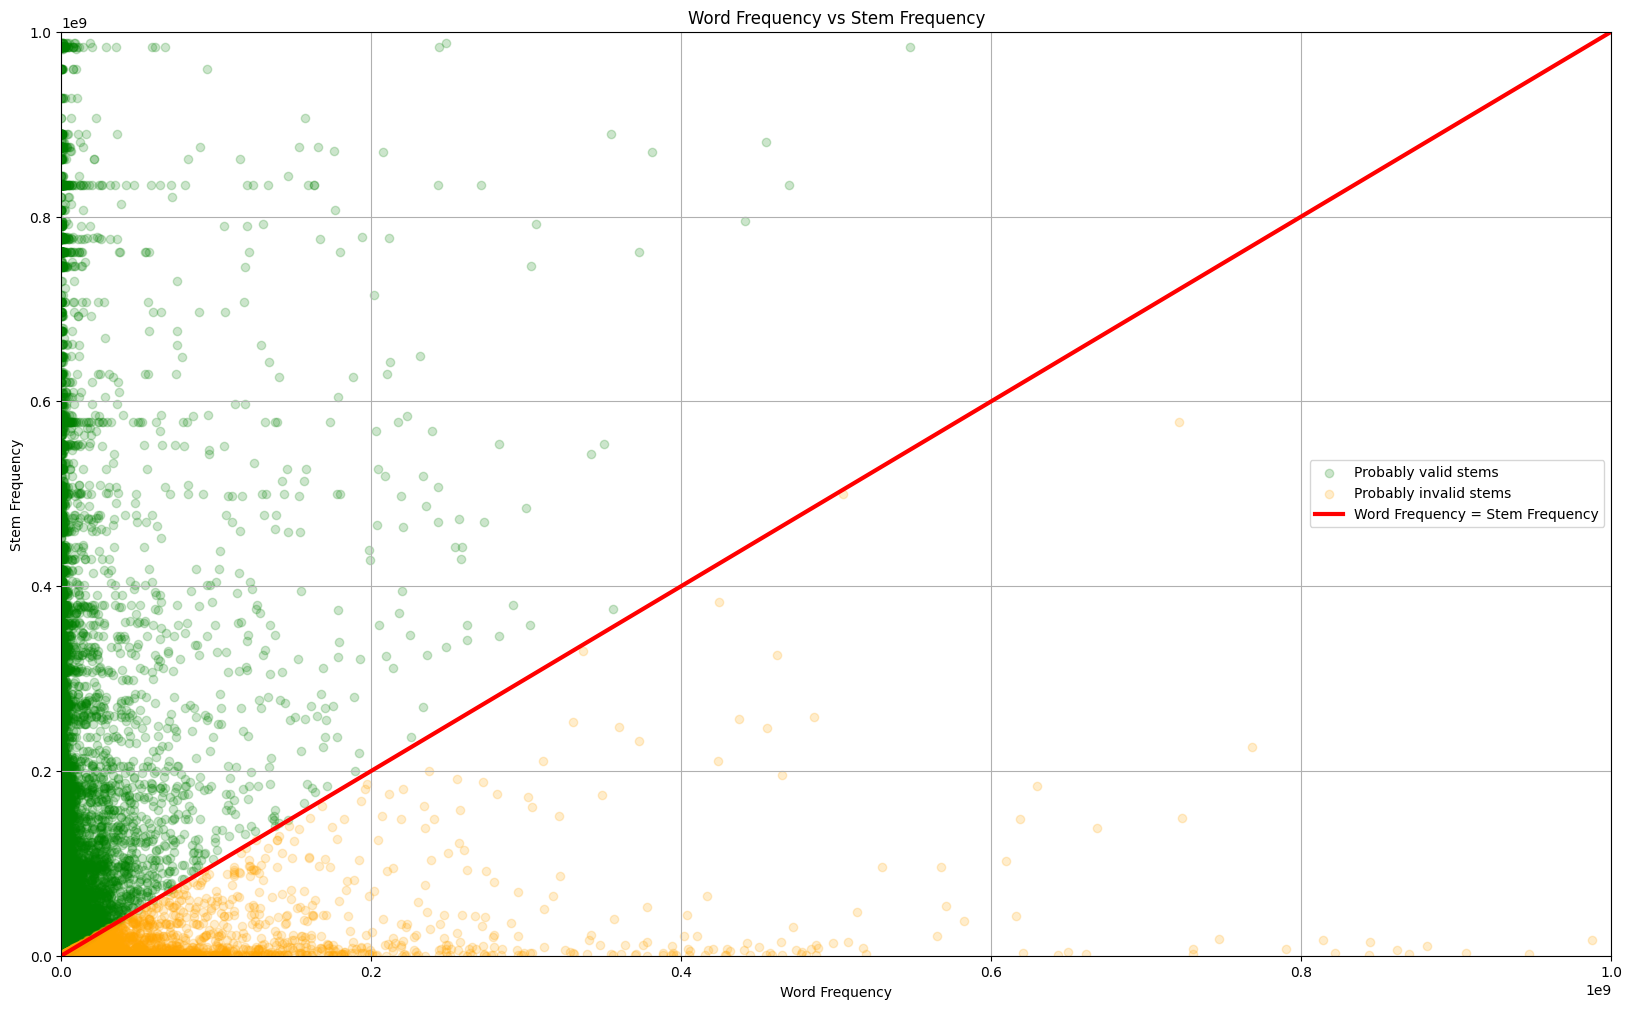

In [13]:
axis_limits = 1e9

plt.figure(figsize=(20, 12))
plt.xlim(right=axis_limits)
plt.ylim(top=axis_limits)

valid_mask = stem_freq >= word_freq
invalid_mask = ~valid_mask

plt.scatter(word_freq[valid_mask], stem_freq[valid_mask], color='green', alpha=0.2, label='Probably valid stems')
plt.scatter(word_freq[invalid_mask], stem_freq[invalid_mask], color='orange', alpha=0.2, label='Probably invalid stems')
plt.plot([0, axis_limits], [0, axis_limits], color='red', linewidth=3, label='Word Frequency = Stem Frequency')

plt.title('Word Frequency vs Stem Frequency')
plt.xlabel('Word Frequency')
plt.ylabel('Stem Frequency')
plt.grid(True)
plt.legend(loc="right")
plt.show()

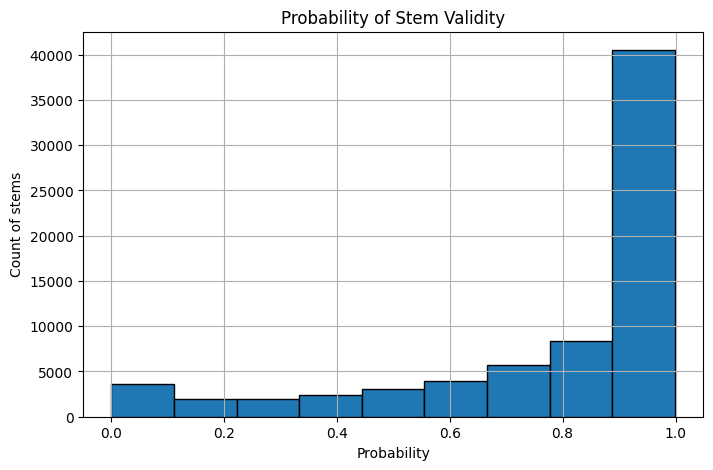

In [14]:
plt.figure(figsize=(8, 5))
plt.hist(probabilities, bins=9, edgecolor='black')
plt.title('Probability of Stem Validity')
plt.xlabel('Probability')
plt.ylabel('Count of stems')
plt.grid(True)
plt.show()

## Dump valid words

### Sorted by frequency

In [15]:
sorted_by_freq = sorted(VALID_WORDS.items(), key=lambda x: x[1][0], reverse=True)
counter = 0

with open('valid_words_sorted_by_frequency.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Rank', 'Word', 'Frequency count', 'Stem', 'Stem valid probability'])
    for word, word_data in sorted_by_freq:
        counter += 1
        freq, stem, stem_val_prob = word_data
        writer.writerow([counter, word, freq, stem, stem_val_prob])

### Sorted alphabetically

In [16]:
sorted_alphabetically = sorted(VALID_WORDS.items(), key=lambda x: x[0])
counter = 0

with open('valid_words_sorted_alphabetically.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['N', 'Word', 'Frequency count', 'Stem', 'Stem valid probability'])
    for word, word_data in sorted_alphabetically:
        counter += 1
        freq, stem, stem_val_prob = word_data
        writer.writerow([counter, word, freq, stem, stem_val_prob])

### The list of words as txt file

In [17]:
with open('valid_words.txt', 'w') as txtfile:
    for word, _ in sorted_alphabetically:
        txtfile.write(word + '\n')